# Confirmatory Analysis

In [ ]:
# Width of 80 ###################################################################

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [19]:
covid_data = pd.read_csv('covid_data_conf.csv')
reddit_data = pd.read_parquet("reddit_data_incl_sent.parquet", engine="pyarrow")
PHEIC_start = pd.to_datetime("2020-01-30")
PHEIC_end = pd.to_datetime("2023-05-05")
START_WEEK_COVID_DATA = pd.to_datetime("2019-12-29").replace(tzinfo=None)

In [20]:
reddit_data["week"] = reddit_data["weeks_centered_2020"]
reddit_data.drop(columns=["user_ID",
                          "post_title_and_body",
                          "timestamp",
                          "weeks_centered_2020"], inplace=True)

In [35]:
covid_data.head()

,week,incidence
0,0,0.00002
1,1,0.00045
2,2,0.00090
3,3,0.01895
4,4,0.12538


In [18]:
reddit_data_testing = reddit_data.sample(frac=0.001)
reddit_data_testing.head()

,is_from_rdepression,is_during_covid,sentiment
2007044,False,False,-0.4893
1861993,False,True,-0.8200
1886804,False,True,-0.3649
919317,True,False,0.9031
1291264,True,False,-0.9876


In [37]:
grouping_cols = ["week", "is_from_rdepression"]

df = reddit_data.groupby(grouping_cols).agg(
        n_posts = ("is_from_rdepression", "size"),
        is_during_covid = ("is_during_covid", "any"),
        sentiment = ("sentiment", "mean"),
    ).reset_index()

In [38]:
df["intensity"] = df["n_posts"] * df["sentiment"]

In [39]:
df.head()

,week,is_from_rdepression,n_posts,is_during_covid,sentiment,intensity
0,-550,False,1,False,0.892200,0.8922
1,-550,True,1,False,-0.906100,-0.9061
2,-548,False,4,False,0.685575,2.7423
3,-547,True,1,False,-0.948300,-0.9483
4,-546,False,4,False,0.298825,1.1953


In [40]:
df = pd.merge(df, covid_data, left_on="week", right_on= "week", how="left")
df.sample().head()

,week,is_from_rdepression,n_posts,is_during_covid,sentiment,intensity,incidence
64,-513,False,1,False,-0.9254,-0.9254,NaN


In [46]:
df.head()

,week,is_from_rdepression,n_posts,is_during_covid,sentiment,intensity,incidence
0,-550,False,1,False,0.892200,0.8922,NaN
1,-550,True,1,False,-0.906100,-0.9061,NaN
2,-548,False,4,False,0.685575,2.7423,NaN
3,-547,True,1,False,-0.948300,-0.9483,NaN
4,-546,False,4,False,0.298825,1.1953,NaN


In [49]:
# group_1 = df[df["is_from_rdepression"] == True]
# others = df[df["is_from_rdepression"] != False]
#
# # Downsample group == 1 to 791 rows
# group_1_downsampled = group_1.sample(n=791, random_state=42)
#
# # Combine back
# df_downsampled = pd.concat([group_1_downsampled, others], ignore_index=True)
scaler = StandardScaler()
cols_in = ["incidence", "n_posts", "is_from_rdepression", "sentiment", "week", "is_during_covid"]
cols_out = ["incidence_std", "n_posts_std", "is_from_rdepression_std", "sentiment_std", "week_std", "is_during_covid_std"]
df[cols_out] = scaler.fit_transform(df[cols_in])
df.to_csv("data.csv")

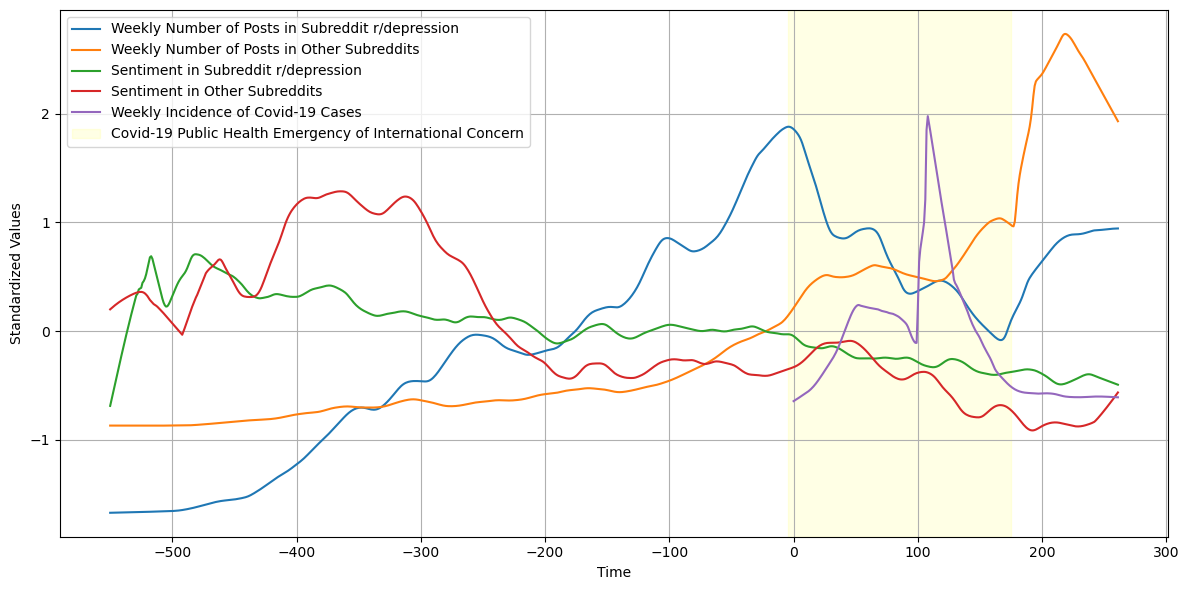

In [61]:
_scaler = StandardScaler()

group_true = df[df['is_from_rdepression'] == True]
group_false = df[df['is_from_rdepression'] == False]

columns = ["n_posts", "sentiment"]
titls = ["Weekly Number of Posts", "Sentiment"]

plt.figure(figsize=(12, 6))

for col, title in zip(columns, titls):
    smoothed_true = lowess(
            scaler.fit_transform(group_true[[col]]).flatten(),
            group_true['week'],
            frac=0.05
            )
    smoothed_false = lowess(
            scaler.fit_transform(group_false[[col]]).flatten(),
            group_false['week'],
            frac=0.05
            )
    plt.plot(smoothed_true[:, 0], smoothed_true[:, 1], label=f"{title} in Subreddit r/depression")
    plt.plot(smoothed_false[:, 0], smoothed_false[:, 1], label=f"{title} in Other Subreddits")

# LOWESS for COVID
lowess_covid = lowess(
        scaler.fit_transform(df[["incidence"]]).flatten(),
        df["week"],
        frac=0.1
        )
plt.plot(lowess_covid[:, 0], lowess_covid[:, 1], label="Weekly Incidence of Covid-19 Cases")

# Vertical lines for the event
diff_weeks_start = (START_WEEK_COVID_DATA - PHEIC_start).days / 7
diff_weeks_end = (PHEIC_end - START_WEEK_COVID_DATA).days / 7
plt.axvspan(diff_weeks_start, diff_weeks_end, color='yellow', alpha=0.1, label = "Covid-19 Public Health Emergency of International Concern")

# Final plot settings
plt.xlabel('Time')
plt.ylabel('Standardized Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


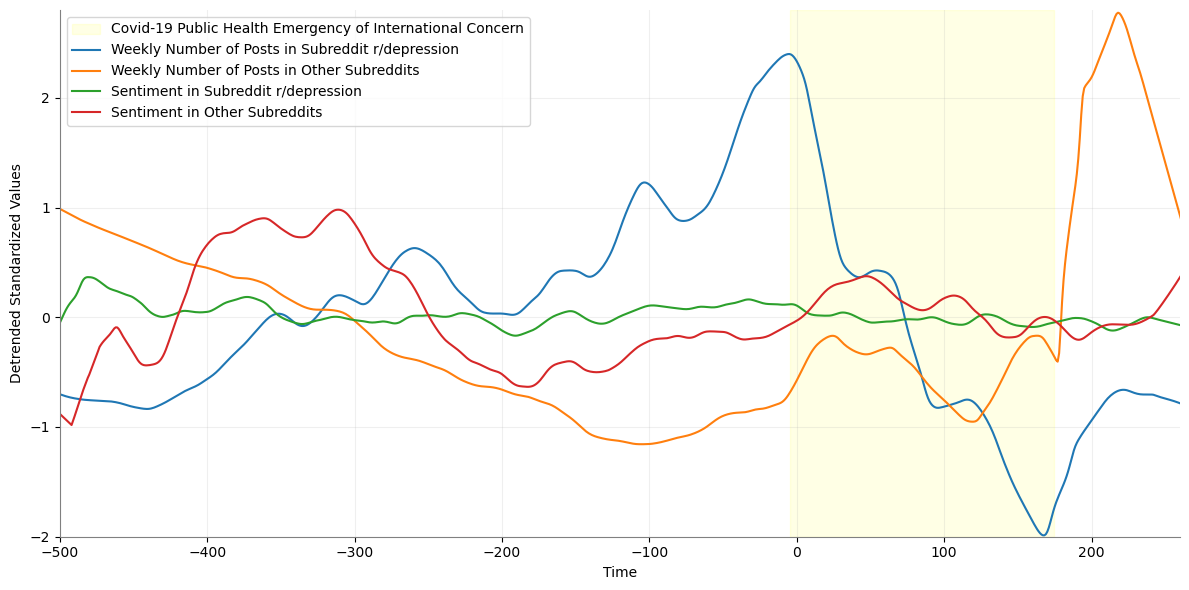

In [89]:
scaler = StandardScaler(with_mean=False, with_std=True)

def detrend_column(x, y):
    model = LinearRegression()
    x_reshaped = x.values.reshape(-1, 1)
    model.fit(x_reshaped, y)
    trend = model.predict(x_reshaped)
    return y - trend

group_true = df[df['is_from_rdepression'] == True]
group_false = df[df['is_from_rdepression'] == False]

columns = ["n_posts", "sentiment"]
titls = ["Weekly Number of Posts", "Sentiment"]

plt.figure(figsize=(12, 6))


plt.axvspan(diff_weeks_start, diff_weeks_end, color='yellow', alpha=0.1, label = "Covid-19 Public Health Emergency of International Concern")

for col, title, color in zip(columns, titls, my_colors):
    detrended_true = detrend_column(group_true['week'], group_true[col])
    detrended_false = detrend_column(group_false['week'], group_false[col])

    smoothed_true = lowess(
        scaler.fit_transform(detrended_true.values.reshape(-1, 1)).flatten(),
        group_true['week'],
        frac=0.05,
    )
    smoothed_false = lowess(
        scaler.fit_transform(detrended_false.values.reshape(-1, 1)).flatten(),
        group_false['week'],
        frac=0.05
    )

    plt.plot(smoothed_true[:, 0], smoothed_true[:, 1], label=f"{title} in Subreddit r/depression")
    plt.plot(smoothed_false[:, 0], smoothed_false[:, 1], label=f"{title} in Other Subreddits")

plt.xlabel('Time')
plt.ylabel('Detrended Standardized Values')
plt.xlim(left=-500, right=260)
plt.ylim(bottom=-2, top=2.8)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')  # x-axis line
ax.spines['left'].set_color('gray')
plt.show()

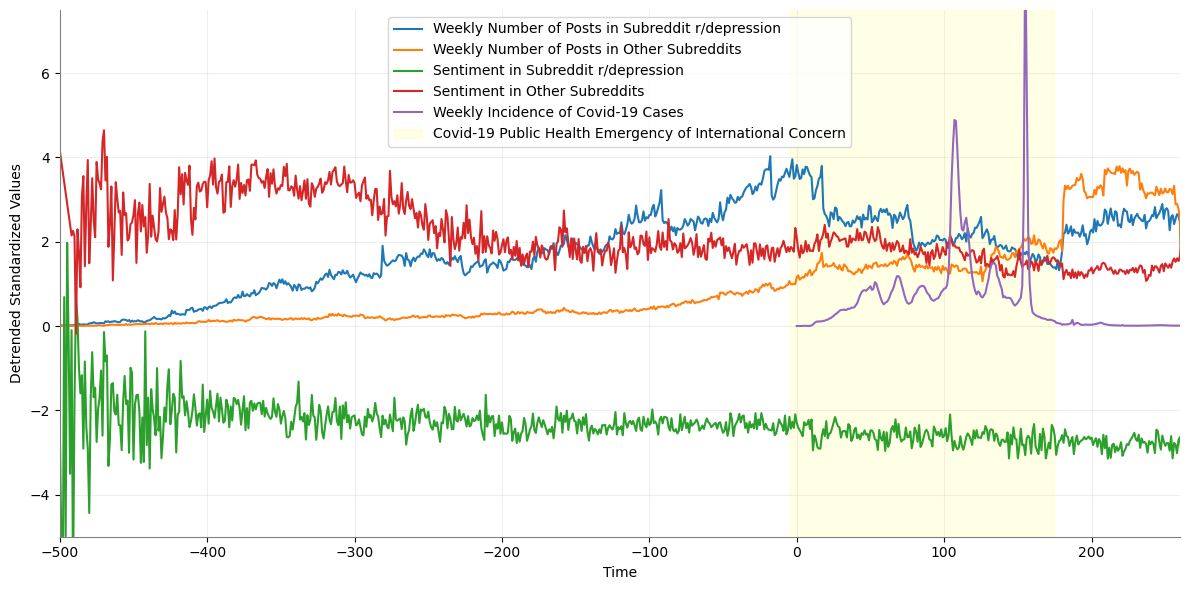

In [90]:

scaler = StandardScaler(with_mean=False)  # scale but do NOT center (no mean subtraction)

group_true = df[df['is_from_rdepression'] == True]
group_false = df[df['is_from_rdepression'] == False]

columns = ["n_posts", "sentiment"]
titles = ["Weekly Number of Posts", "Sentiment"]

plt.figure(figsize=(12, 6))

for col, title in zip(columns, titles):
    # Scale values (without centering)
    scaled_true = scaler.fit_transform(group_true[[col]]).flatten()
    scaled_false = scaler.fit_transform(group_false[[col]]).flatten()

    plt.plot(group_true['week'], scaled_true, label=f"{title} in Subreddit r/depression")
    plt.plot(group_false['week'], scaled_false, label=f"{title} in Other Subreddits")

# Also scale COVID incidence without centering and plot raw scaled values
scaled_covid = scaler.fit_transform(df[["incidence"]]).flatten()
plt.plot(df['week'], scaled_covid, label="Weekly Incidence of Covid-19 Cases")

# Highlight event
diff_weeks_start = (START_WEEK_COVID_DATA - PHEIC_start).days / 7
diff_weeks_end = (PHEIC_end - START_WEEK_COVID_DATA).days / 7
plt.axvspan(diff_weeks_start, diff_weeks_end, color='yellow', alpha=0.1, label="Covid-19 Public Health Emergency of International Concern")

plt.xlabel('Time')
plt.ylabel('Detrended Standardized Values')
plt.xlim(left=-500, right=260)
plt.ylim(bottom=-5, top=7.5)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('gray')  # x-axis line
ax.spines['left'].set_color('gray')
plt.show()

In [111]:
scaler1 = StandardScaler(with_std=False)  # just centering
scaler2 = StandardScaler()                # standardize (z-score)

df = group_true

df['sentiment_std'] = scaler2.fit_transform(df[['sentiment']])

df['is_from_rdepression_std'] = scaler1.fit_transform(df[['is_from_rdepression']])
df['incidence_std'] = scaler2.fit_transform(df[['incidence']])
df['weeks_centered_2020_std'] = scaler2.fit_transform(df[['weeks_centered_2020']])

# Use the standardized variables in the regression formula
model_std = smf.ols('sentiment ~ incidence + weeks_centered_2020', data=df).fit()

# Show summary
print(model_std.summary())
print(df.head())
print(np.corrcoef(df["is_from_rdepression"], df["sentiment"])[0,1])

/var/folders/ps/kh7rtmwn297gt11h5_kln_tr0000gn/T/ipykernel_76233/817059972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_std'] = scaler2.fit_transform(df[['sentiment']])
/var/folders/ps/kh7rtmwn297gt11h5_kln_tr0000gn/T/ipykernel_76233/817059972.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_from_rdepression_std'] = scaler1.fit_transform(df[['is_from_rdepression']])


KeyError: "None of [Index(['incidence'], dtype='object')] are in the [columns]"

In [103]:
X = df[["is_from_rdepression", "sentiment", "n_posts", "weeks_centered_2020", "is_during_covid", "incidence"]]  # replace with your actual column names

# Add a constant (intercept) manually
X = sm.add_constant(X)

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

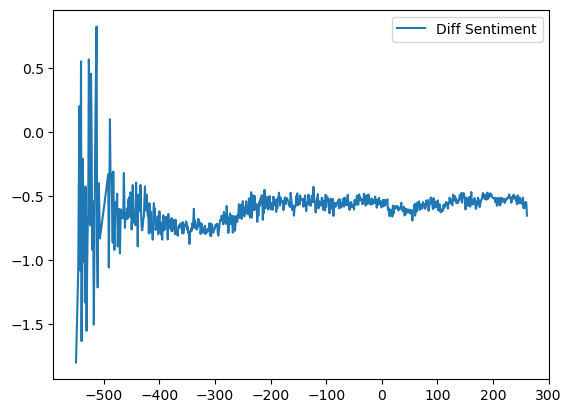

In [98]:
# Select relevant columns plus the key for joining
df_true = group_true[['weeks_centered_2020', 'sentiment', 'n_posts']].copy()
df_false = group_false[['weeks_centered_2020', 'sentiment', 'n_posts']].copy()

# Rename columns in false group to distinguish
df_false = df_false.rename(columns={'sentiment': 'sentiment_false', 'n_posts': 'n_posts_false'})

# Merge on weeks_centered_2020
merged = pd.merge(df_true, df_false, on='weeks_centered_2020', how='inner')

# Calculate differences
merged['diff_sentiment'] = merged['sentiment'] - merged['sentiment_false']
merged['diff_n'] = merged['n_posts'] - merged['n_posts_false']

plt.plot(merged['weeks_centered_2020'], merged['diff_sentiment'], label='Diff Sentiment')
plt.legend()
plt.show()


In [94]:
plt.plot(group_true["weeks_centered_2020"], group_true["diff_sentiment"], label="Sentiment")

KeyError: 'diff_sentiment'

In [112]:
scaler1 = StandardScaler(with_std=False)  # just centering
scaler2 = StandardScaler()                # standardize (z-score)

df = df_conf[df_conf["weeks_since_01_01_2020"] >= 0]

def standardize_group(group):
    return (group - group.mean()) / group.std()

df['n_posts_std'] = df.groupby('is_from_rdepression')['n_posts'].transform(standardize_group)

df['n_posts_std_std'] = scaler2.fit_transform(df[['n_posts_std']])


df['is_from_rdepression_std'] = scaler1.fit_transform(df[['is_from_rdepression']])
df['incidence_std'] = scaler2.fit_transform(df[['incidence']])
df['weeks_centered_2020_std'] = scaler2.fit_transform(df[['weeks_centered_2020']])

# Use the standardized variables in the regression formula
model_std = smf.ols('n_posts_std_std ~ weeks_centered_2020_std + is_from_rdepression_std * incidence_std', data=df).fit()
model_raw = smf.ols('n_posts_std ~ weeks_centered_2020 + is_from_rdepression * incidence', data=df).fit()

# Show summary
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:        n_posts_std_std   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     21.07
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           4.08e-16
Time:                        18:54:26   Log-Likelihood:                -704.09
No. Observations:                 524   AIC:                             1418.
Df Residuals:                     519   BIC:                             1439.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

/var/folders/ps/kh7rtmwn297gt11h5_kln_tr0000gn/T/ipykernel_76233/2682217284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_posts_std'] = df.groupby('is_from_rdepression')['n_posts'].transform(standardize_group)
/var/folders/ps/kh7rtmwn297gt11h5_kln_tr0000gn/T/ipykernel_76233/2682217284.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_posts_std_std'] = scaler2.fit_transform(df[['n_posts_std']])
/var/folders/ps/kh7rtmwn297gt11h5_kln_tr0000gn/T/ipykernel_76233/2682217284.py:14: SettingWith

In [14]:
print(model_std.summary())

                            OLS Regression Results                            
Dep. Variable:        n_posts_std_std   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     21.07
Date:                Mon, 07 Jul 2025   Prob (F-statistic):           4.08e-16
Time:                        13:34:03   Log-Likelihood:                -704.09
No. Observations:                 524   AIC:                             1418.
Df Residuals:                     519   BIC:                             1439.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [15]:
from statsmodels.regression.linear_model import GLSAR

X = df[['incidence']]
X = sm.add_constant(X)
y = df['n_posts']

model = GLSAR(y, X, rho=1)  # AR(1)
res = model.iterative_fit(10)
print(model.summary())

AttributeError: 'GLSAR' object has no attribute 'summary'

In [76]:
df_conf = df_conf.dropna(subset=['n_posts', 'is_from_rdepression', 'incidence'])
# 1) OLS regression with formula (on standardized dependent variable)
model1 = smf.ols('n_posts_std ~ is_from_rdepression * is_during_covid', data=df_conf).fit()

# 2) GLSAR regression on raw data to account for AR(1) errors
X = df_conf[["is_from_rdepression", "incidence"]]
X = sm.add_constant(X)
Y = df_conf['n_posts']

model2 = sm.GLSAR(Y, X, rho=1)
results = model2.iterative_fit(maxiter=10)  # <-- use model2, not model

print(results.summary())

# Print OLS summary afterwards
print(model1.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [69]:
df_conf.columns

Index(['weeks_centered_2020', 'is_from_rdepression', 'posts_titles_and_bodies',
       'n_posts', 'is_during_covid', 'weeks_since_01_01_2020',
       '7_day_incidence', 'raw_timestamp', 'raw_cases', 'incidence',
       'n_posts_std'],
      dtype='object')

In [1]:
# stuff
# reddit_data["weeks_centered_2020"] = ((reddit_data["timestamp"] - START_WEEK_COVID_DATA).dt.days // 7).astype(int)

In [ ]:
reddit_data['sentiment'] = reddit_data['post_title_and_body'].progress_apply(calc_sentiment)
reddit_data.to_parquet("reddit_data_incl_sent.parquet", engine="pyarrow")
reddit_data = pd.read_parquet("reddit_data_incl_sent.parquet")

In [ ]:
my_sia = SIA()
def calc_sentiment(text: str) -> float:
    if not isinstance(text, str):
        return np.nan
    return my_sia.polarity_scores(text = text)['compound']